In [1]:
import numpy as np
import sympy as sp
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import pandas as pd

# ==========================================================
# Parameter (flach, ohne Klassen)
# ==========================================================
g = 9.81

# Geometrie
L1 = 0.155
L2 = 0.240
lP = 0.1917

# Massen
mS = 0.0274
mP = 0.0  # 0.0510   # <- 0.0 wenn keine Zusatzmasse montiert ist
m2 = mS + mP

# Trägheitsmomente
J1_hat = 2.89e-2
J0_hat = J1_hat + m2 * L1**2

l2 = L2 / 2.0
J2_hat = (1 / 12) * mS * L2**2 + mS * l2**2 + mP * lP**2

# Reibungsparameter
mu_V1 = 50.91e-2
mu_H1 = 93.58e-3
mu_V2 = 1.332e-5
mu_H2 = 3.018e-4

epsilon = 0.01
tau_max = 4.0


# ==========================================================
# Eingangsfunktion aus 3.4 (HIER 1:1 einsetzen)
# ==========================================================
def input_tau(t: float) -> float:
    # TODO: exakt eure 3.4-Funktion hier einsetzen (dein bisheriger Block ist nur Platzhalter)
    if 0 < t < 1.0:
        tau = 0.62 * t
    elif 1 <= t <= 1.4:
        tau = -4.12 * t + 4.74
    elif 1.4 < t < 2:
        tau = 1.72 * t - 3.43
    else:
        tau = 0.0

    return float(np.clip(tau, -tau_max, tau_max))


# ==========================================================
# SymPy: theta1_ddot, theta2_ddot symbolisch aufstellen + lambdify
# ==========================================================
def make_furuta_accel_lambdas(
    *,
    g, L1, l2, J0_hat, J2_hat, m2,
    mu_V1, mu_H1, mu_V2, mu_H2,
    epsilon,
    simplify_expr: bool = True
):
    # Symbole
    th1, th1d, th2, th2d, tau = sp.symbols("th1 th1d th2 th2d tau", real=True)

    # Reibung: mu_V*v + mu_H*tanh(v/epsilon)
    b1 = mu_V1 * th1d + mu_H1 * sp.tanh(th1d / epsilon)
    b2 = mu_V2 * th2d + mu_H2 * sp.tanh(th2d / epsilon)
    
    # Massenmatrix
    M11 = J0_hat + J2_hat * sp.sin(th2) ** 2
    M12 = m2 * L1 * l2 * sp.cos(th2)
    M = sp.Matrix([[M11, M12],
                   [M12, J2_hat]])

    # Rechte Seite
    r1 = (
        tau
        + m2 * L1 * l2 * sp.sin(th2) * th2d**2
        - J2_hat * sp.sin(2 * th2) * th1d * th2d
        - b1
    )
    r2 = (
        sp.Rational(1, 2) * J2_hat * sp.sin(2 * th2) * th1d**2
        - m2 * g * l2 * sp.sin(th2)
        - b2
    )
    r = sp.Matrix([r1, r2])

    # Lösung ohne inv(): stabiler
    th1dd, th2dd = M.LUsolve(r)

    if simplify_expr:
        th1dd = sp.simplify(th1dd)
        th2dd = sp.simplify(th2dd)

    # Lambdify (numpy)
    accel_fun = sp.lambdify((th1, th1d, th2, th2d, tau), (th1dd, th2dd), modules="numpy")

    return accel_fun, (th1dd, th2dd)


# einmalig erzeugen
accel_fun, accel_exprs = make_furuta_accel_lambdas(
    g=g, L1=L1, l2=l2, J0_hat=J0_hat, J2_hat=J2_hat, m2=m2,
    mu_V1=mu_V1, mu_H1=mu_H1, mu_V2=mu_V2, mu_H2=mu_H2,
    epsilon=epsilon,
    simplify_expr=True,   # wenn's beim Start zu lange dauert -> False
)

3.4 Überprüfen Sie Ihre Implementierung für den Eingangsverlauf
auf dem Zeitintervall t ∈ [0 s, 10 s], Schrittweite Δt = 1 ms, mit den im OLAT 
bereitgestellten Validierungsdaten validationSimulation.csv.

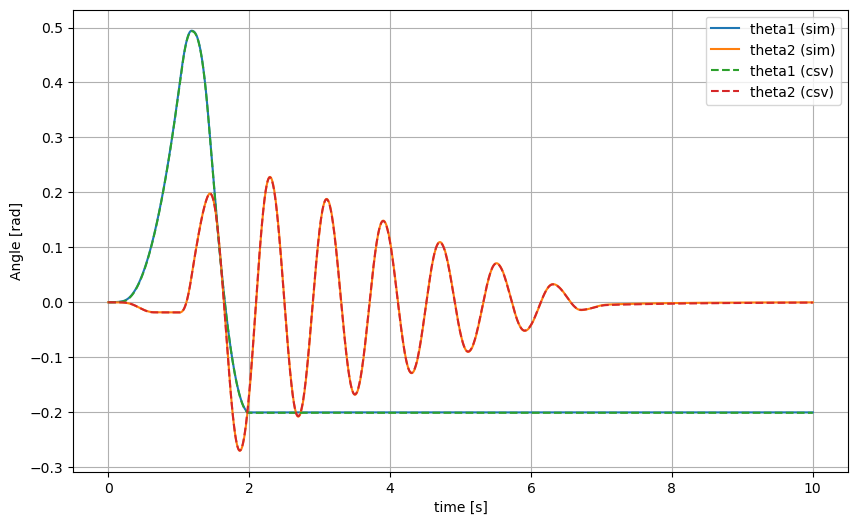

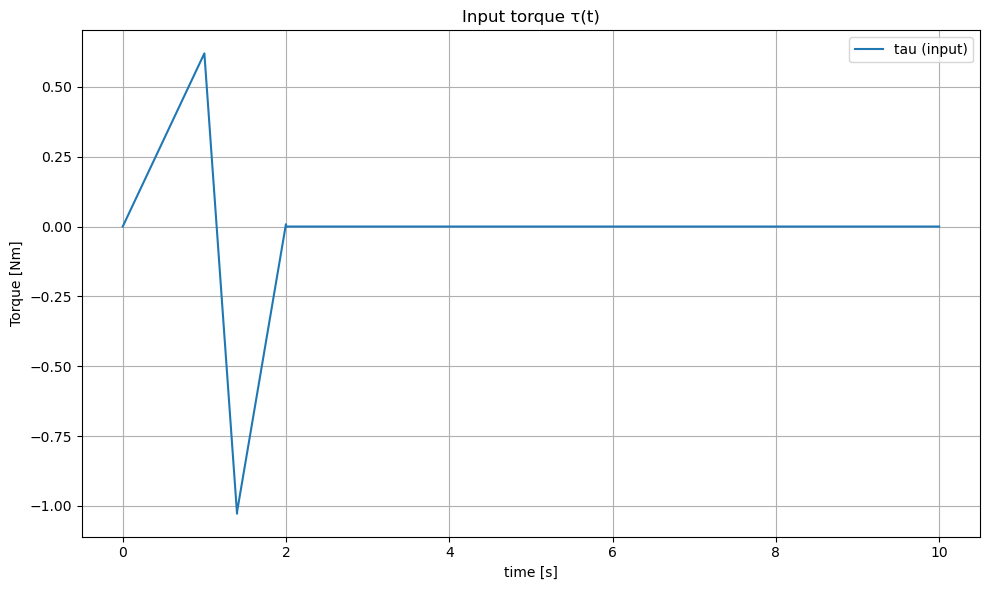

RMSE theta1: 0.0007381095538715748
RMSE theta2: 0.0011584298617269954


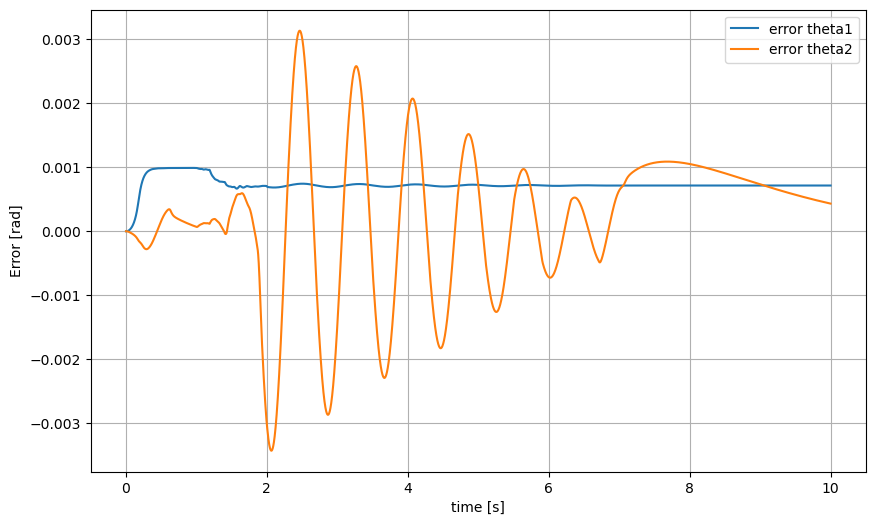

In [3]:
# ==========================================================
# Zustandsraummodell (nutzt lambdified Beschleunigungen)
# x = [theta1, theta1_dot, theta2, theta2_dot]
# ==========================================================
def furuta_dynamics(t, x):
    theta1, theta1_dot, theta2, theta2_dot = x
    tau = input_tau(t)

    theta1_ddot, theta2_ddot = accel_fun(theta1, theta1_dot, theta2, theta2_dot, tau)

    # lambdify liefert numpy scalars/arrays -> float cast für solve_ivp
    return [theta1_dot, float(theta1_ddot), theta2_dot, float(theta2_ddot)]


# ==========================================================
# Simulation + CSV Vergleich
# ==========================================================
df = pd.read_csv("validationSimulation.csv")
t_csv = df["time"].values
theta1_csv = df["F: theta1"].values
theta2_csv = df["F: theta2"].values

# Anfangszustand (wie bei dir; muss ggf. zur CSV passen)
x0 = [0.0, 0.0, 0.0, 0.0]

# Tipp: direkt auf CSV-Zeitpunkten integrieren, damit Vergleich 1:1 ist
sol = solve_ivp(
    furuta_dynamics,
    (float(t_csv[0]), float(t_csv[-1])),
    x0,
    t_eval=t_csv,
    rtol=1e-6,
    atol=1e-9,
    max_step=1e-2,
)

theta1_sim = sol.y[0]
theta2_sim = sol.y[2]
tau_sim = np.array([input_tau(t) for t in t_csv])

plt.figure(figsize=(10, 6))
plt.plot(t_csv, theta1_sim, label="theta1 (sim)")
plt.plot(t_csv, theta2_sim, label="theta2 (sim)")
plt.plot(t_csv, theta1_csv, "--", label="theta1 (csv)")
plt.plot(t_csv, theta2_csv, "--", label="theta2 (csv)")
plt.ylabel("Angle [rad]")
plt.xlabel("time [s]")
plt.legend()
plt.grid(True)
plt.show()

# ==========================================================
# Separater Plot für das Eingangsmoment tau(t)
# ==========================================================
plt.figure(figsize=(10, 6))
plt.plot(t_csv, tau_sim, label="tau (input)")
plt.ylabel("Torque [Nm]")
plt.xlabel("time [s]")
plt.title("Input torque τ(t)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Optional: Fehlerplot + RMSE
e1 = theta1_sim - theta1_csv
e2 = theta2_sim - theta2_csv
rmse1 = np.sqrt(np.mean(e1**2))
rmse2 = np.sqrt(np.mean(e2**2))
print("RMSE theta1:", rmse1)
print("RMSE theta2:", rmse2)

plt.figure(figsize=(10, 6))
plt.plot(t_csv, e1, label="error theta1")
plt.plot(t_csv, e2, label="error theta2")
plt.ylabel("Error [rad]")
plt.xlabel("time [s]")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
P